In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define functions

The `plot_corr_matrix` function is used to plot correlation heatmaps.
This function will be used twice: (1) to plot the initial correlation matrix for all (valid) input features,
    and (2) to plot the final correlation matrix for all features that survived the feature reduction steps.

In [3]:
def plot_corr_matrix(in_corr_matrix):
    """
    Plots the correlation matrix as a heatmap using seaborn
    
    """
    sns.set(style = 'white')
    f, ax = plt.subplots(figsize = (12, 9))
    
    # Generate a mask for the upper triangle
    corr_mask = np.zeros_like(in_corr_matrix, dtype = np.bool)
    corr_mask[np.triu_indices_from(corr_mask)] = True
    
    ax.set_title('CORRELATION MATRIX (%s FEATURES)' %len(in_corr_matrix),
                 fontsize = 14, fontweight = 'bold')
    
    sns.heatmap(in_corr_matrix, mask = corr_mask,
                cmap = sns.diverging_palette(220, 10, as_cmap=True),
                square = True, ax = ax, 
                vmin = -1, vmax = 1)

The `plot_feature_reduction_results` function is used to plot a line graph that shows 
the absolute correlation of each input feature with the target feature. The features that did not survive the feature reduction
steps are distinguished by using a different color.

In [4]:
def plot_feature_reduction_results(indf):
    """
    Plots the feature reduction results to visualize the discarded features
    
    """
    
    sns.set(style = 'whitegrid')
    f, ax = plt.subplots(figsize = (12, 9))
    
    # TODO: Show x labels if they are visible (i.e., not too many)
    ax = sns.barplot(x = 'index', y = 'corr_with_y', hue = 'Survived', 
                     palette = sns.color_palette('Paired'), data = indf)
    
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_title('FEATURE REDUCTION RESULTS', fontsize = 14, 
                 fontweight = 'bold')
    
    plt.xlabel('Features', fontsize = 14)
    plt.ylabel('Correlation with Target', fontsize = 14)
    #plt.legend(fontsize = 14)
    plt.show()

The `multcolin` function perform feature reduction on the set of (valid) input features.

After performing some initial checks (e.g., empty dataframe) it discards any features that are not numeric.
The list of features that survive the feature reduction steps are returned by this function.

In [5]:
def multcolin(indf, y_vals, min_vars_to_keep, corr_tol, condition_ind_tol,
              verbose, export_csv):
    """
    Performs feature reduction on *numeric* features using:
        1. Pairwise correlation analysis, followed by
        2. Multi-collinearity analysis
        
    min_vars_to_keep:   Stop further feature reduction if this threshold is met
    corr_tol:           If the absolute correlation between two variables is 
                        higher, one of them will be dropped (the one that has 
                        high corr with target)
    condition_ind_tol:  Used to detect high levels of multicollinearity
    
    To disable the pairwise correlation step, set corr_tol to 1.0 

    """
    
    # If empty dataframe, raise an error
    if indf.shape[0] == 0:
        raise RuntimeError('The input dataframe is empty!')
        
    # Number of input features (original)
    in_col_ct = len(indf.columns)

    # Discard categorical vars, if any
    indf = indf.loc[:, indf.dtypes != object]
    num_col_ct = len(indf.columns)
    
    # If one or less (valid) column, print message and return
    if num_col_ct <= 1:
        print ('The input dataframe contains one or less column! \
               Exiting function without executing.')
        return 

    # If number of columns <= min_vars_to_keep, raise an error
    if num_col_ct <= min_vars_to_keep:
        raise RuntimeError('The number of valid features = min_vars_to_keep. \
                            Choose a higher value for min_vars_to_keep.') 
    
    
    # If y_vals are not numeric, raise warning and return
    if type(y[0]) == 'object':
        raise ValueError('The target/output vector is non-numeric.') 
        
    ## Everything looks good -- let's proceed! (aka the "happy path")
    
    # Print the number of discarded non-numeric features (if any) 
    if in_col_ct != num_col_ct and verbose == True:
        print ("%s non-numeric feature(s) discarded" %(in_col_ct - num_col_ct))
    
    # Correlation matrix for all independent vars
    corr_matrix = indf.corr()
    num_features = len(corr_matrix)
    
    # Export the initial correlation matrix for all input features
    if export_csv == True:
        corr_matrix.to_csv('initial_corr_matrix.csv')
        
    if verbose == 1:
        print (f'# of input vars = {num_features}', '\n')
    
    # Plot the initial correlation matrix
    plot_corr_matrix(corr_matrix)
    
    # Correlations with the target/output vector
    corr_with_y = {}
    for var in indf.columns:
        corr_with_y[var] = y_vals.corr(indf[var])
    
    # Save those in a dataframe
    orig_vars_df = pd.DataFrame.from_dict([corr_with_y]).T
    orig_vars_df.columns = ['corr_with_y']
        
    # For each column in the corr matrix
    print ('Running Pairwise Correlation Analysis')
    for col in corr_matrix:
        if col in corr_matrix.keys():
            this_col, these_vars = [], []
            
            for i in range(len(corr_matrix)):
                
                this_var = corr_matrix.keys()[i]
                this_corr = corr_matrix[col][i]
                
                if abs(this_corr) == 1.0 and col != this_var:
                    highly_corr = 0
                else:
                    highly_corr = (1 if abs(this_corr) > corr_tol 
                                   else -1) * abs(corr_with_y[this_var])
                
                this_col.append(highly_corr)
                these_vars.append(corr_matrix.keys()[i])
            
            # Initialize the mask
            mask = np.ones(len(this_col), dtype = bool) 
            
            # To keep track of the number of columns deleted
            del_col_ct = 0
            
            for n, j in enumerate(this_col):
                # Delete if (a) a var is correlated with others and do not have
                # the best corr with dep, or (b) completely corr with the 'col'
                mask[n] = not (j != max(this_col) and j >= 0)
                
                if j != max(this_col) and j >= 0:
                    
                    if verbose == 1:
                        print ('    Dropping %s {Corr with %s=%.5f}' 
                               %(these_vars[n], this_var, corr_matrix[col][n]))
                        
                    # Delete the column from corr matrix
                    corr_matrix.pop('%s' %these_vars[n])
                    corr_with_y.pop('%s' %these_vars[n])
                    del_col_ct += 1
                    
            # Delete the corresponding row(s) from the corr matrix
            corr_matrix = corr_matrix[mask]
    
    if verbose == 1 and corr_tol != 1:
        print ('\n# of vars after eliminating high pairwise correlations =', 
               len(corr_matrix), '\n')
    
    # Multicollinearity
    if num_features > min_vars_to_keep:
        print ('Running Multi-collinearity Analysis')
    
        while True:
            num_features -= 1
            
            # Update the list of columns
            cols = corr_matrix.keys() 
            
            # Eigen values and vectors
            eigen_vals, eigen_vectors = np.linalg.eig(corr_matrix) 
            
            # Calculate the max of all conditinon indices
            c_ind = max((max(eigen_vals) / eigen_vals) ** 0.5)
            
            # If the condition index <= 30 then multicolin is not an issue
            if c_ind <= condition_ind_tol or num_features == min_vars_to_keep:
                break
            
            for i, val in enumerate(eigen_vals):
                if val == min(eigen_vals):   # Min value, close to zero
                    # Look into that vector
                    this_eigen_vector = eigen_vectors[:, i]
                    max_w = max(abs(this_eigen_vector))
                    
                    for j, vec in enumerate(this_eigen_vector):
                        # Var that has the max weight on that vector
                        if abs(vec) == max_w:
                            # Initialize
                            mask = np.ones(len(corr_matrix), dtype = bool)
                            for n, col in enumerate(corr_matrix.keys()):
                                mask[n] = n != j
                                
                            #TODO: Also print the set of features
                            # with which this var is correlated
                            if verbose == 1:
                                print ('    Dropping %s {Weight=%.2f}' 
                                       %(corr_matrix.keys()[j], max_w))
                                
                            # Delete row
                            corr_matrix = corr_matrix[mask]  
                            # Delete column
                            corr_matrix.pop(cols[j])
                                                     
        
        if verbose == 1:
            print ('\n # of vars after multicolinearity analyis =', 
                   len(corr_matrix), '\n')
    
    # Export the final correlation matrix for the survivors
    if export_csv == True:
        corr_matrix.to_csv('final_corr_matrix.csv')
        
    # Survivors
    surv_vars = {k:v for (k,v) in corr_with_y.items() 
                if k in corr_matrix.keys()}
    
    # Create a dataframe (to be exported)
    surv_vars_df = pd.DataFrame.from_dict([surv_vars]).T
    surv_vars_df.columns = ['Survived']
    
    orig_vars_df = orig_vars_df.merge(surv_vars_df, left_index = True, 
                                      right_index = True, how = 'left')
    
    orig_vars_df.loc[pd.isnull(orig_vars_df['Survived']) == False, 
                     'Survived'] = 'Y'
                     
    orig_vars_df['Survived'].fillna('N', inplace = True)
    
    orig_vars_df = orig_vars_df.reset_index().sort_values(by = 'corr_with_y', 
                                           ascending = False)

    if export_csv == True:
        orig_vars_df.to_csv('multcolin_results.csv')
    
    # Plot the final correlation matrix
    plot_corr_matrix(corr_matrix)
     
    # Plot the feature reduction results
    plot_feature_reduction_results(orig_vars_df)
    
    return surv_vars

# Demonstration using the Boston Housing data
#### Details about the Boston Housing data can be found here: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html

In [6]:
from sklearn.datasets import load_boston

boston = load_boston()
print(boston.data.shape)

(506, 13)


The `multcolin` function expects the dataset (X values) to be a dataframe with column names
So let's convert this numpy array into a Pandas dataframe

In [10]:
X = pd.DataFrame(boston['data'])

And the y values must be a Series
So let's convert the target values into a Pandas Series

In [11]:
y = pd.Series(boston['target'])

In [12]:
# let's take a quick look at the data
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


The `multcolin` function also expects column names. Let's assign column names to this dataframe.

In [13]:
X.columns = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS',
             'RAD', 'TAX', 'PTRATIO', 'B1000', 'LSTAT', 'MEDV']

Now this dataset doesn't suffer from multi-collinearity (you can check this separately by using a piece of code from the `'multcolin` function that calculates the condition indices for each feature). So let's (try to) introduce some multicollinearity!

In [14]:
# Create a new feature that is correlated with three other features

X['EXTRA'] = .01*X['RAD'] + .02*X['ZN'] - .003*X['CRIM']    \
        + np.random.uniform()

Let's perform feature reduction on this dataset by calling the `multcolin` function.
Please note that I've used condition_ind_tol = 5 just for this demo.
This value is TOO LOW! In practice, you should use a value between 15 and 30. (30 is the most commonly used value.)

# of input vars = 14 

Running Pairwise Correlation Analysis
    Dropping ZN {Corr with EXTRA=1.00000}

# of vars after eliminating high pairwise correlations = 13 

Running Multi-collinearity Analysis
    Dropping PTRATIO {Weight=0.72}
    Dropping RM {Weight=0.77}
    Dropping RAD {Weight=0.77}

 # of vars after multicolinearity analyis = 10 



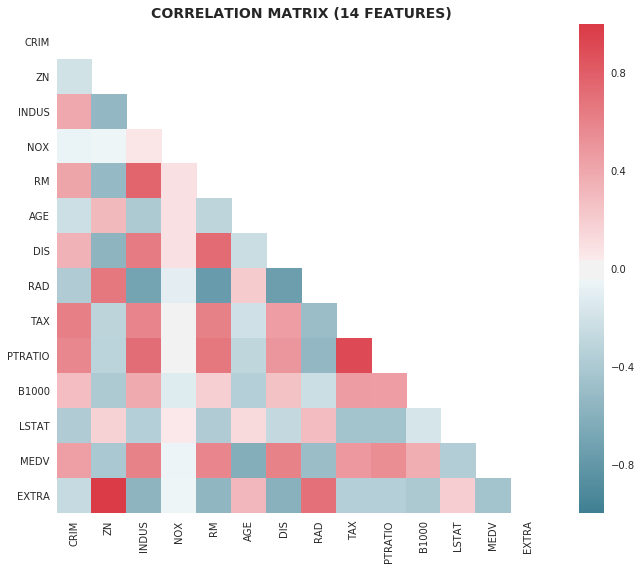

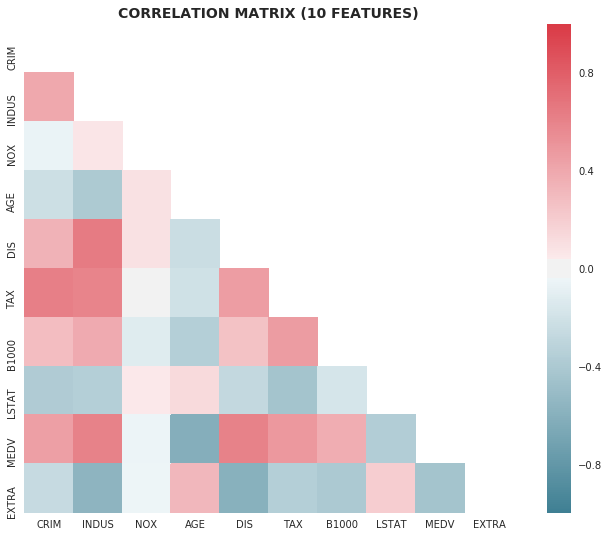

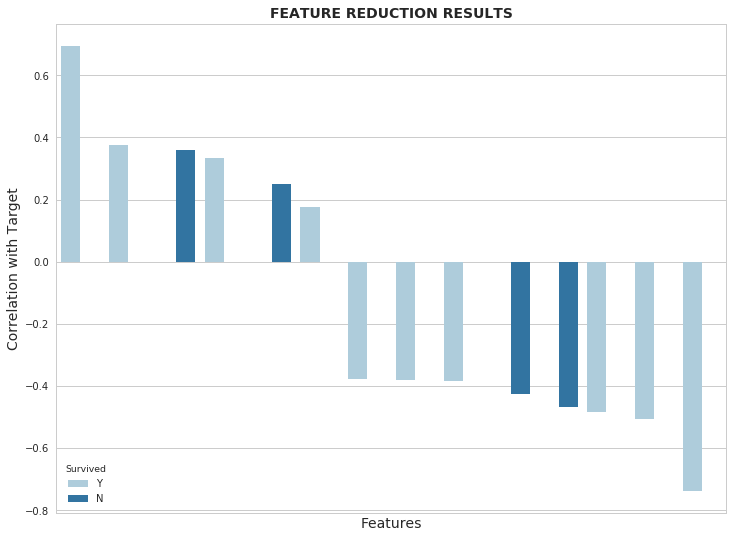

In [15]:
vars_to_keep = multcolin(X, y, min_vars_to_keep = 5, corr_tol = .95, 
                             condition_ind_tol = 5, verbose = 1, 
                             export_csv = 1)

Out of 14 input features, `ZN` was dropped because it has a high correlation with `EXTRA`.
Then three more features, `PTRATIO`, `RM`, and `RAD` were dropped because these variables caused multicollinearity in the data (they were correlated with two or more other variables).

The correlation matrix heatmaps demonstrates the reduction in pairwise correlations. While the Feature Reduction Results plot shows which features (with respect to where they are in terms of their correlation with the target) are discarded. This can be useful if you want to ensure that not too many of the important features (on either ends of the spectrum) are discarded. 